# Taller 3 - MINE 4101: Ciencia de Datos Aplicada
## Semestre: 2023-20

Javier Andrés Ramírez Silva
Código 201821781
 
**Gabriel Hernández Reyes 
Código 201728589
 
 
**Nicolas Esteban Niño Vega 
Código 202324436


**Juan Diego Ospina Aguirre 
Código 201814547



## Caso

El área de fidelización de una empresa de telecomunicaciones tiene como una de sus metas disminuir la tasa de churn (abandono) por parte de sus clientes. Por esta razón, desea construir modelos de machine learning que permitan predecir si un cliente es propenso abandonar los servicios que actualmente tiene contratados con la empresa. Una vez construidos, estos modelos deben ser disponibilizados a través de una API REST que pueda ser consumida por la plataforma que es usada por los asesores de call center usando dicha predicción para ofrecer nuevos productos o servicios a los clientes más propensos al abandono.

### Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
!pip install --upgrade pandas-profiling

  Using cached pandas_profiling-3.6.6-py2.py3-none-any.whl (324 kB)
  Using cached ydata_profiling-4.6.1-py2.py3-none-any.whl (357 kB)
  Using cached wordcloud-1.9.2-cp39-cp39-win_amd64.whl (153 kB)
  Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
  Using cached visions-0.7.5-py3-none-any.whl (102 kB)
  Using cached numba-0.58.1-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached phik-0.12.3-cp39-cp39-win_amd64.whl (663 kB)
  Using cached pydantic-2.5.1-py3-none-any.whl (381 kB)
  Using cached typeguard-4.1.5-py3-none-any.whl (34 kB)
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)
  Using cached llvmlite-0.41.1-cp39-cp39-win_amd64.whl (28.1 MB)
  Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
!pip install imbalanced-learn

In [3]:
pip install --upgrade threadpoolctl

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import sklearn
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport

ModuleNotFoundError: No module named 'pandas_profiling'

In [2]:
pd.set_option('display.max_columns', None) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 200) # Numero máximo de filas a mostar

### Carga de los datos
* La carga de los datos se realiza desde de un archivo JSON y se almacena en una estructuras de datos de Pandas conocida como dataframe.

In [37]:
historical_data = pd.read_json('./churn_historic.json')
future_data = pd.read_json('./churn_future.json')

### Exploración y descripción básica
Empezamos revisando las dimensiones del conjunto de datos

In [4]:
historical_data.shape

(6000, 21)

In [5]:
future_data.shape

(1000, 21)

Se quiere entender los datos que proporciona la organización. Por esto se les solicita que se entregue el diccionario de datos y en base a los datos y el diccionario se tiene buena información para comenzar:

| Field              | Description                                               |
|--------------------|-----------------------------------------------------------|
| customerID         | Customer ID                                               |
| gender             | Whether the customer is a male or a female                |
| SeniorCitizen      | Whether the customer is a senior citizen or not (1, 0)    |
| Partner            | Whether the customer has a partner or not (Yes, No)       |
| Dependents         | Whether the customer has dependents or not (Yes, No)      |
| tenure             | Number of months the customer has stayed with the company |
| PhoneService       | Whether the customer has a phone service or not (Yes, No) |
| MultipleLines      | Whether the customer has multiple lines or not (Yes, No, No phone service) |
| InternetService    | Customer’s internet service provider (DSL, Fiber optic, No) |
| OnlineSecurity     | Whether the customer has online security or not (Yes, No, No internet service) |
| OnlineBackup       | Whether the customer has online backup or not (Yes, No, No internet service) |
| DeviceProtection   | Whether the customer has device protection or not (Yes, No, No internet service) |
| TechSupport        | Whether the customer has tech support or not (Yes, No, No internet service) |
| StreamingTV        | Whether the customer has streaming TV or not (Yes, No, No internet service) |
| StreamingMovies    | Whether the customer has streaming movies or not (Yes, No, No internet service) |
| Contract           | The contract term of the customer (Month-to-month, One year, Two year) |
| PaperlessBilling   | Whether the customer has paperless billing or not (Yes, No) |
| PaymentMethod      | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges     | The amount charged to the customer monthly                |
| TotalCharges       | The total amount charged to the customer                   |
| Churn              | Whether the customer churned or not (Yes or No)           |


Se compartieron datos histróricos de 6000 clientes con 21 columnas
Se compartieron datos futuros (predicciones) de 1000 clientes con 21 columnas.

A continuación se previsualiza una muestra aleatoria de los datos:

In [6]:
historical_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2203,0164-APGRB,Female,0,No,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,114.90,8496.7,No
5484,7033-CLAMM,Female,0,Yes,Yes,48,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.20,1027.25,No
3147,8885-QSQBX,Female,0,No,No,1,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),49.55,49.55,No
2494,8046-DNVTL,Male,0,Yes,No,62,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Credit card (automatic),38.60,2345.55,No
3205,4304-XUMGI,Male,1,Yes,Yes,50,Yes,Yes,DSL,Yes,Yes,Yes,No,No,Yes,Two year,Yes,Bank transfer (automatic),75.15,3822.45,No


In [7]:
future_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
440,4786-UKSNZ,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.2,Yes
327,3740-RLMVT,Male,1,Yes,No,67,Yes,No,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Bank transfer (automatic),60.95,4119.4,No
99,7123-WQUHX,Male,0,No,No,38,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),95.00,3605.6,No
609,6229-LSCKB,Male,1,No,No,6,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.70,497.6,No
579,0310-MVLET,Female,0,Yes,Yes,61,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.15,6010.05,Yes


Empezamos revisando que no hayan entradas duplicadas por cliente.

In [8]:
duplicados_historical = historical_data.duplicated(subset=['customerID'])
print("Número de filas duplicadas por la columna 'customerID' en historical_data:", duplicados_historical.sum())

Número de filas duplicadas por la columna 'customerID' en historical_data: 0


In [9]:
duplicados_future = future_data.duplicated(subset=['customerID'])
print("Número de filas duplicadas por la columna 'customerID' en future_data:", duplicados_future.sum())

Número de filas duplicadas por la columna 'customerID' en future_data: 0


Vemos que no existen entradas duplicadas por cliente.

Revismos el tipo de dato asociado a cada columna del set de datos junto con su cuenta de no-nulos:

In [10]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   SeniorCitizen     6000 non-null   int64  
 3   Partner           6000 non-null   object 
 4   Dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   PhoneService      6000 non-null   object 
 7   MultipleLines     6000 non-null   object 
 8   InternetService   6000 non-null   object 
 9   OnlineSecurity    6000 non-null   object 
 10  OnlineBackup      6000 non-null   object 
 11  DeviceProtection  6000 non-null   object 
 12  TechSupport       6000 non-null   object 
 13  StreamingTV       6000 non-null   object 
 14  StreamingMovies   6000 non-null   object 
 15  Contract          6000 non-null   object 
 16  PaperlessBilling  6000 non-null   object 


In [11]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1000 non-null   object 
 1   gender            1000 non-null   object 
 2   SeniorCitizen     1000 non-null   int64  
 3   Partner           1000 non-null   object 
 4   Dependents        1000 non-null   object 
 5   tenure            1000 non-null   int64  
 6   PhoneService      1000 non-null   object 
 7   MultipleLines     1000 non-null   object 
 8   InternetService   1000 non-null   object 
 9   OnlineSecurity    1000 non-null   object 
 10  OnlineBackup      1000 non-null   object 
 11  DeviceProtection  1000 non-null   object 
 12  TechSupport       1000 non-null   object 
 13  StreamingTV       1000 non-null   object 
 14  StreamingMovies   1000 non-null   object 
 15  Contract          1000 non-null   object 
 16  PaperlessBilling  1000 non-null   object 
 

Realizamos un perfilamiento de datos

In [15]:
profile = ProfileReport(historical_data)

In [16]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

A partir del perfilamiento vemos que no existen problemas significativos de calidad de datos que se deban corregir. Excepto la variable TotalCharges. Esta variable contiene valores de tipo 'str', 'int' y 'float'. Por ello vamos a primero debes convertir los valores de la columna TotalCharges a un tipo numérico.

In [12]:
historical_data['TotalCharges'] = pd.to_numeric(historical_data['TotalCharges'], errors='coerce')

In [13]:
# Dividimos los datos en características (X) y etiquetas (y)
X_historical = historical_data.drop('Churn', axis=1)
y_historical = historical_data['Churn']

In [14]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_historical, y_historical, test_size=0.2, random_state=42, stratify=y_historical)

# Dividimos el conjunto temporal en conjuntos de prueba y validación
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [15]:
# Definimos las columnas numéricas y categóricas
numeric_features = X_historical.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_historical.select_dtypes(include=['object']).columns

In [16]:
# Creamos transformadores para las columnas numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
# Creamos el preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 1. [20%] Integración del proceso de transformación de datos, entrenamiento y predicción: 
Utilizando la función Pipeline de Scikit-Learn, encapsule los procesos secuenciales de transformación, entrenamiento y predicción requeridos para dar solución al problema planteado. Tenga en cuenta que a partir de los datos originales el pipeline debe estar en capacidad de realizar todas las transformaciones de datos necesarias para realizar las labores de entrenamiento y predicción. Es decir, posterior a las fases de exploración y análisis de calidad de los datos, no se deben implementar procesos de transformación de datos por fuera del pipeline.

In [27]:
# Creamos el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Aplicar SMOTE para balancear las clases
    ('classifier', RandomForestClassifier(random_state=42))
])

## [10%] Entrenamiento de un modelo baseline: 
Utilizando un algoritmo simple y sin mayores consideraciones a nivel de experimentación, transformación de datos y selección de hiper-parámetros, entrene un primer modelo de clasificación. Reporte sus métricas de error.

In [28]:
# Entrenamos el pipeline con los datos de entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHo...
                                                  Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [23]:
# Realizamos predicciones en el conjunto de prueba
y_pred_test = pipeline.predict(X_test)

In [24]:
print("Classification Report (Test Set):\n", classification_report(y_test, y_pred_test))

Classification Report (Test Set):
               precision    recall  f1-score   support

          No       0.86      0.87      0.86       441
         Yes       0.62      0.59      0.61       159

    accuracy                           0.80       600
   macro avg       0.74      0.73      0.73       600
weighted avg       0.79      0.80      0.79       600



In [25]:
# Realizamos predicciones en el conjunto de validación
y_pred_val = pipeline.predict(X_val)

In [26]:
print("Classification Report (Validation Set):\n", classification_report(y_val, y_pred_val))

Classification Report (Validation Set):
               precision    recall  f1-score   support

          No       0.83      0.88      0.85       441
         Yes       0.60      0.49      0.54       159

    accuracy                           0.78       600
   macro avg       0.71      0.69      0.70       600
weighted avg       0.77      0.78      0.77       600



## [20%] Selección automática del mejor modelo: 
Realice una búsqueda en grilla con validación cruzada en donde experimente con al menos 3 algoritmos y sus respectivos conjuntos de hiper-parámetros para encontrar el mejor modelo de clasificación optimizando la métrica F1 o ROC AUC.

Se experimentará con 3 algoritmos:
* Random Forest Classifier (RF)
* Gradient Boosting Classifier (GB)
* Support Vector Classifier (SVC)

Empezamos definiendo los pipelines para cada algoritmo:

In [28]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [27]:
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [29]:
pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42))
])

Ahora la grilla de hiperparámetros a probar para cada algoritmo:

In [30]:
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'smote__k_neighbors': [3, 5, 7]
}

In [31]:
param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 10],
    'smote__k_neighbors': [3, 5, 7]
}

In [32]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'smote__k_neighbors': [3, 5, 7]
}

Procedemos a realizar la búsqueda en grilla con validación cruzada para cada pipeline:

In [33]:
scorer = make_scorer(f1_score, pos_label='Yes')

In [34]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring=scorer, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [35]:
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring=scorer, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

KeyboardInterrupt: 

In [44]:
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring=scorer, n_jobs=-1)
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy=...
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__kernel': ['linear', 'rbf'],
                         'smote__k_neighbors': [3, 5, 7]},
             scoring=make_scorer(f1_score, pos_label=Yes))

Y obtenemos los mejores hiperparámetros para cada algoritmo:

In [45]:
best_params_rf = grid_search_rf.best_params_
best_params_gb = grid_search_gb.best_params_
best_params_svc = grid_search_svc.best_params_

print(f"Mejores hiperparámetros para RandomForestClassifier: {best_params_rf}")
print(f"Mejores hiperparámetros para GradientBoostingClassifier: {best_params_gb}")
print(f"Mejores hiperparámetros para SVC: {best_params_svc}")

Mejores hiperparámetros para RandomForestClassifier: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'smote__k_neighbors': 3}
Mejores hiperparámetros para GradientBoostingClassifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'smote__k_neighbors': 3}
Mejores hiperparámetros para SVC: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'smote__k_neighbors': 7}


Evaluamos ahora el rendimiento de cada modelo para el set de prueba

In [46]:
# Evaluate performance on the test set for each model
y_pred_test_rf = grid_search_rf.predict(X_test)
f1_test_rf = f1_score(y_test, y_pred_test_rf, pos_label='Yes')
print(f"F1 score on the test set for RandomForestClassifier: {f1_test_rf}")

y_pred_test_gb = grid_search_gb.predict(X_test)
f1_test_gb = f1_score(y_test, y_pred_test_gb, pos_label='Yes')
print(f"F1 score on the test set for GradientBoostingClassifier: {f1_test_gb}")

y_pred_test_svc = grid_search_svc.predict(X_test)
f1_test_svc = f1_score(y_test, y_pred_test_svc, pos_label='Yes')
print(f"F1 score on the test set for SVC: {f1_test_svc}")

F1 score on the test set for RandomForestClassifier: 0.6486486486486487
F1 score on the test set for GradientBoostingClassifier: 0.6593406593406594
F1 score on the test set for SVC: 0.6466165413533834


Tengamos en cuenta que el F1-Score calculado es para la clase positiva, es decir para predecir los clientes que abandonan (que es el objetivo del churn).

Imprimimos ahora el reporte de clasificación para cada algoritmo con sus mejores hiperparámetros para el set de prueba:

In [53]:
print("Classification Report Random Forest (Conjunto de prueba):\n", classification_report(y_test, y_pred_test_rf))

Classification Report Random Forest (Conjunto de prueba):
               precision    recall  f1-score   support

          No       0.90      0.79      0.84       441
         Yes       0.57      0.75      0.65       159

    accuracy                           0.78       600
   macro avg       0.73      0.77      0.75       600
weighted avg       0.81      0.78      0.79       600



In [54]:
print("Classification Report Gradient Boosting (Conjunto de prueba):\n", classification_report(y_test, y_pred_test_gb))

Classification Report Gradient Boosting (Conjunto de prueba):
               precision    recall  f1-score   support

          No       0.90      0.81      0.85       441
         Yes       0.59      0.75      0.66       159

    accuracy                           0.79       600
   macro avg       0.74      0.78      0.76       600
weighted avg       0.82      0.79      0.80       600



In [55]:
print("Classification Report SVC (Conjunto de prueba):\n", classification_report(y_test, y_pred_test_svc))

Classification Report SVC (Conjunto de prueba):
               precision    recall  f1-score   support

          No       0.92      0.75      0.82       441
         Yes       0.54      0.81      0.65       159

    accuracy                           0.77       600
   macro avg       0.73      0.78      0.74       600
weighted avg       0.82      0.77      0.78       600



El modelo Gradient Boosting se destaca como la mejor opción para predecir la clase 'Sí' en el contexto de churn. Con una sensibilidad del 75%, demuestra ser efectivo al identificar aproximadamente tres cuartas partes de los casos reales de abandono de clientes. Además, su puntuación F1 del 66% refleja un equilibrio sólido entre precisión y sensibilidad. Estos resultados respaldan la elección de Gradient Boosting, subrayando su capacidad para predecir de manera confiable la posible pérdida de clientes.

Para identificar overfitting o underfitting, comparamos el rendimiento del modelo en entrenamiento, validación y prueba:

In [56]:
y_train_pred = grid_search_gb.predict(X_train)
print("Classification Report Gradient Boosting (Conjunto de entrenamiento):\n", classification_report(y_train, y_train_pred))

Classification Report Gradient Boosting (Conjunto de entrenamiento):
               precision    recall  f1-score   support

          No       0.90      0.83      0.86      3526
         Yes       0.60      0.74      0.66      1274

    accuracy                           0.80      4800
   macro avg       0.75      0.78      0.76      4800
weighted avg       0.82      0.80      0.81      4800



In [57]:
print("Classification Report Gradient Boosting (Conjunto de prueba):\n", classification_report(y_test, y_pred_test_gb))

Classification Report Gradient Boosting (Conjunto de prueba):
               precision    recall  f1-score   support

          No       0.90      0.81      0.85       441
         Yes       0.59      0.75      0.66       159

    accuracy                           0.79       600
   macro avg       0.74      0.78      0.76       600
weighted avg       0.82      0.79      0.80       600



In [58]:
y_val_pred = grid_search_gb.predict(X_val)
print("Classification Report Gradient Boosting (Conjunto de validación):\n", classification_report(y_val, y_val_pred))

Classification Report Gradient Boosting (Conjunto de validación):
               precision    recall  f1-score   support

          No       0.88      0.79      0.84       441
         Yes       0.55      0.71      0.62       159

    accuracy                           0.77       600
   macro avg       0.72      0.75      0.73       600
weighted avg       0.80      0.77      0.78       600



Revisamos ahora sus matrices de confusión

In [60]:
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicciones")
    ax.set_ylabel("Actual")

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

In [62]:
plot_confusion_matrix(axes[0], y_train, y_train_pred, title="Confusion Matrix - Train Set")
plot_confusion_matrix(axes[1], y_test, y_pred_test_gb, title="Confusion Matrix - Train Set")
plot_confusion_matrix(axes[2], y_val, y_val_pred, title="Confusion Matrix - Validation Set")

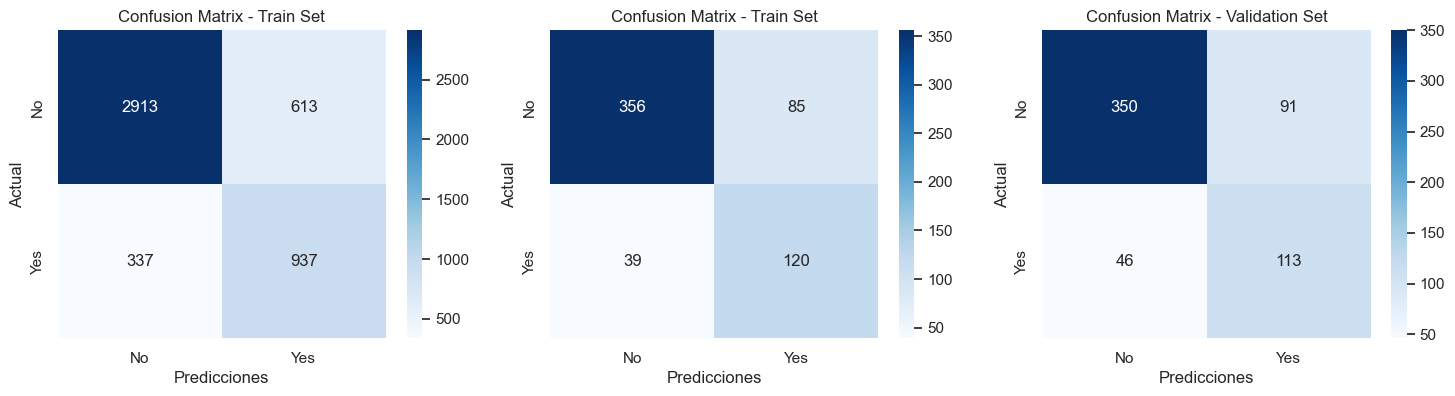

In [64]:
%matplotlib inline
plt.show()

Tras analizar los informes de clasificación para el modelo Gradient Boosting en los conjuntos de entrenamiento, prueba y validación, se observa un rendimiento general robusto y equilibrado. En el conjunto de entrenamiento, el modelo presenta altos niveles de precisión, recall y f1-score tanto para la clase positiva como para la clase negativa, indicando una capacidad efectiva de generalización. Este rendimiento se mantiene consistente en el conjunto de prueba, sugiriendo que el modelo no sufre de overfitting y es capaz de generalizar bien a datos no vistos. Aunque se observa una ligera disminución en las métricas de precisión y recall en el conjunto de validación, el modelo sigue siendo capaz de predecir la clase "Yes" de manera razonable. En conjunto, estos resultados respaldan la elección del modelo Gradient Boosting con los hiperparámetros óptimos, proporcionando un equilibrio sólido entre precisión y capacidad de generalización para predecir la probabilidad de churn.

Finalmente, elaboramos el pipeline para el modelo de Gradient Boosting con los mejores hiperparámetros

In [18]:
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=42
)

In [19]:
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_gb_model)
])

In [20]:
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHo...
                                                  Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(n_estimators=200,
                                            random_state=42))])

Exportamos ambos pipelines:

In [68]:
# Exportamos el pipeline para el punto 2
joblib.dump(pipeline, 'pipeline_punto2.joblib')

['pipeline_punto2.joblib']

In [21]:
# Exportamos el pipeline para el punto 3
joblib.dump(pipeline_gb, 'pipeline_punto3.joblib')

['pipeline_punto3.joblib']

In [43]:
historical_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5772,9617-UDPEU,Female,0,No,No,22,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.25,412.55,No
3483,8687-BAFGU,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,74.00,74.00,No
1291,8246-SHFGA,Male,0,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),21.10,385.55,No
3945,9800-ONTFE,Female,0,Yes,Yes,22,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.80,1615.10,No
5010,6064-ZATLR,Female,0,No,No,27,Yes,No,DSL,Yes,Yes,No,No,No,No,Two year,No,Bank transfer (automatic),52.85,1498.65,No


In [45]:
x_prueba = historical_data.sample(5)
x_prueba = x_prueba.drop('Churn', axis=1)
x_prueba

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
503,6942-LBFDP,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.55,33.60
5495,0186-CAERR,Male,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),116.30,8309.55
2000,5141-ZUVBH,Female,0,No,Yes,9,Yes,No,Fiber optic,Yes,No,Yes,Yes,No,Yes,Month-to-month,No,Bank transfer (automatic),93.00,870.25
708,4694-PHWFW,Female,0,No,Yes,8,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,170.90
1478,0463-WZZKO,Male,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),20.75,67.10


In [47]:
pipeline_gb.predict(x_prueba)

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [48]:
x_prueba.to_dict(orient='records')

[{'customerID': '6942-LBFDP',
  'gender': 'Female',
  'SeniorCitizen': 0,
  'Partner': 'No',
  'Dependents': 'No',
  'tenure': 2,
  'PhoneService': 'Yes',
  'MultipleLines': 'No',
  'InternetService': 'No',
  'OnlineSecurity': 'No internet service',
  'OnlineBackup': 'No internet service',
  'DeviceProtection': 'No internet service',
  'TechSupport': 'No internet service',
  'StreamingTV': 'No internet service',
  'StreamingMovies': 'No internet service',
  'Contract': 'Month-to-month',
  'PaperlessBilling': 'Yes',
  'PaymentMethod': 'Mailed check',
  'MonthlyCharges': 20.55,
  'TotalCharges': 33.6},
 {'customerID': '0186-CAERR',
  'gender': 'Male',
  'SeniorCitizen': 0,
  'Partner': 'No',
  'Dependents': 'No',
  'tenure': 71,
  'PhoneService': 'Yes',
  'MultipleLines': 'Yes',
  'InternetService': 'Fiber optic',
  'OnlineSecurity': 'Yes',
  'OnlineBackup': 'Yes',
  'DeviceProtection': 'Yes',
  'TechSupport': 'Yes',
  'StreamingTV': 'Yes',
  'StreamingMovies': 'Yes',
  'Contract': 'One 

In [25]:
modelo_prueba = pipeline_gb.steps[-1][1]

In [26]:
modelo_prueba.feature_importances_

array([0.        , 0.08620868, 0.01628147, ..., 0.00534861, 0.0986249 ,
       0.00050271])

In [43]:
future_copy = future_data.copy()

In [44]:
future_copy = future_copy.sample(frac=1, random_state=42)

In [45]:
partes = np.array_split(future_copy, 7)

In [47]:
df_lunes = partes[0]
df_martes = partes[1]
df_miercoles = partes[2]
df_jueves = partes[3]
df_viernes = partes[4]
df_sabado = partes[5]
df_domingo = partes[6]

In [52]:
X_lunes = df_lunes.drop('Churn', axis=1)
X_martes = df_martes.drop('Churn', axis=1)
X_miercoles = df_miercoles.drop('Churn', axis=1)
X_jueves = df_jueves.drop('Churn', axis=1)
X_viernes = df_viernes.drop('Churn', axis=1)
X_sabado = df_sabado.drop('Churn', axis=1)
X_domingo = df_domingo.drop('Churn', axis=1)

In [55]:
import requests
import random

In [56]:
url_baseline = 'http://localhost:8080/api/cienciadedatos-taller3-prediction-models/get-prediction-a-b-test-baseline/predict'
url_final = 'http://localhost:8080/api/cienciadedatos-taller3-prediction-models/get-prediction-a-b-test-final/predict'

In [73]:
def calcular_predicciones_ab_test(df):
    for indice, fila in df.iterrows():
        data = []
        data.append(fila.to_dict())
        numero_aleatorio = random.random()
        if numero_aleatorio < 0.5:
            requests.post(url_baseline, json=data)
        else:
            requests.post(url_final, json=data)

In [74]:
y_lunes_pred = calcular_predicciones_ab_test(X_lunes)

KeyboardInterrupt: 